## Forest metrics calculation v1

pyForMetrix es un paquete de Python para extraer métricas comúnmente utilizadas en silvicultura a partir de datos de escaneo láser/LiDAR. Sus principales funcionalidades incluyen cálculos basados ​​en gráficos y píxeles, así como el manejo de grandes conjuntos de datos. Este cuaderno explora sus funcionalidades.

Más información disponible aquí.
Además, utilizaremos PyVista, una biblioteca auxiliar para el Kit de Herramientas de Visualización (VTK) que proporciona una interfaz Pythonica y bien documentada que expone el potente backend de visualización de VTK para facilitar la creación rápida de prototipos, el análisis y la integración visual de conjuntos de datos con referencia espacial. Para la visualización en Jupyter Notebook, se necesitan las bibliotecas ipywidgets y trame.

Finalmente, utilizaremos rioxarray, una extensión de la biblioteca Xarray que se centra en datos ráster geoespaciales. Proporciona un acceso sencillo a la información de georreferenciación y a las transformaciones geoespaciales mediante las estructuras de datos multidimensionales etiquetadas de Xarray.

#Configuración

El primer paso es crear un entorno conda usando Python 3.10. Luego, activar el nuevo entorno.

Finalmente, instalar las bibliotecas mencionadas anteriormente.

In [ ]:
#conda create -n lidar_metrics -c conda-forge python=3.10 numpy=1.26.4 pandas=2.1.4 scipy=1.11.4 xarray=2023.12.0
#conda activate lidar_metrics
#conda install -c conda-forge laspy open3d rioxarray pyvista trame matplotlib ipywidgets rasterio geopandas pyproj gdal git
#pip install pyForMetrix

In [ ]:
#conda install -c conda-forge jupyterlab ipykernel
#python -m ipykernel install --user --name lidar_metrics --display-name "lidar_metrics"

In [ ]:
#conda activate lidar_metrics
#jupyter lab

In [16]:
#conda activate lidar_metrics
#conda install -c conda-forge pyvista trame trame-vtk trame-vuetify trame-server trame-client

In [1]:
import numpy as np
import ipywidgets
import laspy
from pyForMetrix.metrix import RasterMetrics
import open3d as o3d
import rioxarray
import pyvista as pv
import trame
import matplotlib.pyplot as plt

In [2]:
# see https://tutorial.pyvista.org/tutorial/00_jupyter/index.html
pv.set_jupyter_backend('client')

# Obtención de datos LiDAR

Primero, necesitamos un conjunto de datos de nube de puntos. Puede usar el suyo propio o descargar un conjunto de datos de muestra,

por ejemplo, del Ayuntamiento de Vancouver:

https://webtransfer.vancouver.ca/opendata/2018LiDAR/4830E_54560N.zip

Descomprime este archivo tras la descarga para encontrar un archivo .las, que utilizaremos a continuación.

Necesitamos cargar la nube de puntos en un array de NumPy. Dependiendo de las métricas que obtengamos posteriormente, también será necesario cargar diferentes atributos. En este ejemplo, se requiere la nube de puntos 3D junto con la información de clasificación y el número de ecos.

In [3]:
inFile = laspy.read(r"D:\LISAR\4830E_54560N\4830E_54560N.las")
coords = np.vstack([inFile.x,
inFile.y,

inFile.z]).transpose()

points = {
'points': coords,
'echo_number': inFile.return_number,
'classification': inFile.classification
}

In [4]:
points

{'points': array([[4.83172390e+05, 5.45608753e+06, 1.02880000e+02],
        [4.83172600e+05, 5.45608831e+06, 1.03080000e+02],
        [4.83172480e+05, 5.45608786e+06, 1.02280000e+02],
        ...,
        [4.83974210e+05, 5.45647113e+06, 1.20580000e+02],
        [4.83973480e+05, 5.45647096e+06, 1.18260000e+02],
        [4.83961830e+05, 5.45644180e+06, 2.31940000e+02]]),
 'echo_number': <SubFieldView([1 1 2 ... 1 2 1])>,
 'classification': <SubFieldView([5 5 5 ... 5 5 7])>}

# Visualización
Utilizaremos laspy para leer el archivo .las y PyVista para la visualización.

In [5]:
las=laspy.read(r"D:\LISAR\4830E_54560N\4830E_54560N.las")

In [6]:
# Access the point data (e.g., X, Y, Z coordinates)
puntos = las.xyz
# Create a PyVista PolyData object from the points
cloud = pv.PolyData(puntos)

In [7]:
cloud

PolyData,Information
N Cells,65122534
N Points,65122534
N Strips,0
X Bounds,"4.830e+05, 4.840e+05"
Y Bounds,"5.456e+06, 5.457e+06"
Z Bounds,"-9.879e+01, 5.029e+02"
N Arrays,0


In [8]:
# We can now visualize the point cloud
pv.plot(
puntos,
scalars=puntos[:, 2],
render_points_as_spheres=True,
point_size=2,
show_scalar_bar=False,
)

Widget(value='<iframe src="http://localhost:62461/index.html?ui=P_0x219f28f9d50_0&reconnect=auto" class="pyvis…

 JS Error => error: ResizeObserver loop completed with undelivered notifications.
 JS Error => error: ResizeObserver loop completed with undelivered notifications.


# Métricas ráster

Tras importar el paquete pyForMetrics, podemos crear un objeto RasterMetrics o un objeto
PlotMetrics, según la aplicación. Comencemos trabajando con RasterMetrics,
que calculará el conjunto de métricas para cada celda de un ráster superpuesto a los datos de la nube de puntos.

In [10]:
rm = RasterMetrics(points, raster_size=25)

El código anterior puede tardar en ejecutarse, ya que al crear el objeto RasterMetrics,

la nube de puntos se rasteriza a las celdas finales. El tiempo de ejecución aumentará con más
puntos y un tamaño de ráster menor.

A continuación, seleccionamos las métricas que queremos calcular. pyForMetrix incluye varias
métricas predefinidas, convenientemente agrupadas en dos colecciones: publicaciones, donde se toman
métricas de diferentes publicaciones de la literatura, y tipos, que agrupa
las métricas por su tipo. Más adelante, veremos cómo crear nuestras propias calculadoras de métricas. Por
ahora, utilizaremos las presentadas por White et al. (2015): Comparing ALS and Image-Based Point Cloud Metrics and Modelled Forest Inventory Attributes in a Complex
Coastal Forest Environment in Forests 2015,6, 3704-3732.

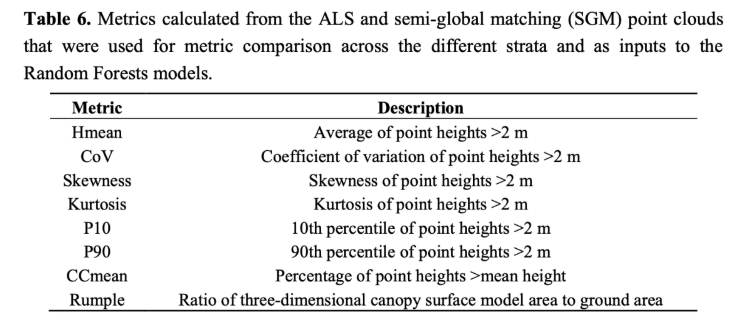

In [22]:
from IPython import display
display.Image(r"D:/LISAR/Table6.png")

In [11]:
from pyForMetrix.metricCalculators.publications import MCalc_Woods_et_al_2009
mc = MCalc_Woods_et_al_2009()
metrics = rm.calc_custom_metrics(metrics=mc)

Con la última línea, creamos un objeto xarray.DataArray que contiene las métricas para cada píxel

In [12]:
print(metrics)

<xarray.DataArray (y: 40, x: 40, val: 26)>
array([[[ 8.89500000e+01,  8.90200000e+01,  8.90700000e+01, ...,
          3.68335834e+00,  7.01144926e-01,  2.27517370e-01],
        [ 8.89300000e+01,  9.17100000e+01,  9.63400000e+01, ...,
          5.82563263e-01,  5.32337210e-01,  4.13955542e-01],
        [ 9.60300000e+01,  1.02950000e+02,  1.11197000e+02, ...,
         -1.95949508e-01,  4.53641988e-01,  4.48952305e-01],
        ...,
        [ 9.25090000e+01,  1.08470000e+02,  1.12550000e+02, ...,
          2.28676927e+00,  4.67347898e-01,  4.64552502e-01],
        [ 8.41600000e+01,  1.19140000e+02,  1.21410000e+02, ...,
          2.54644842e+00,  5.05866552e-01,  5.01203720e-01],
        [ 8.68360000e+01,  1.20400000e+02,  1.22620000e+02, ...,
          2.98616310e+00,  4.79139806e-01,  4.74055514e-01]],

       [[ 8.92000000e+01,  8.92500000e+01,  8.93100000e+01, ...,
          2.91807758e+01,  9.37620045e-01,  6.62214074e-02],
        [ 8.91300000e+01,  8.91700000e+01,  8.92200000e+01, 

Utilizando rioxarray, podemos guardar los valores (aquí: la métrica Hmean, es decir, el percentil 90 de altura) en un archivo ráster

In [13]:
print(metrics.coords['val'].values)


['p10' 'p20' 'p30' 'p40' 'p50' 'p60' 'p70' 'p80' 'p90' 'p100' 'd10' 'd20'
 'd30' 'd40' 'd50' 'd60' 'd70' 'd80' 'd90' 'h_mean' 'h_stddev' 'h_absdev'
 'h_skew' 'h_kurtosis' 'p_first_returns' 'p_first_veg_returns']


In [14]:
tmp = metrics.sel(val='h_mean')

In [15]:
tmp

<xarray.DataArray (y: 40, x: 40)>
array([[ 95.48483478, 103.89187423, 117.72166673, ..., 113.29673197,
        119.19258052, 122.19304279],
       [ 90.54303126,  90.06048383,  95.46701908, ..., 120.78357879,
        120.07429822, 120.29361967],
       [101.39345439,  93.68431294,  89.77200194, ..., 120.82265147,
        119.88214499, 108.95601859],
       ...,
       [101.77792729,  99.71148642,  99.64143922, ...,  97.41240389,
         92.30302422,  96.2628974 ],
       [101.86598287, 101.09634135, 104.98367926, ...,  93.42450459,
         90.69197939,  90.88373135],
       [105.58608913, 105.39229531, 112.28213011, ...,  91.18662625,
         90.70861601,  89.90593456]])
Coordinates:
  * y        (y) float64 5.456e+06 5.456e+06 5.456e+06 ... 5.457e+06 5.457e+06
  * x        (x) float64 4.83e+05 4.83e+05 4.831e+05 ... 4.84e+05 4.84e+05
    val      <U19 'h_mean'

Representa la altura media (mean height) de los puntos LiDAR dentro de cada celda

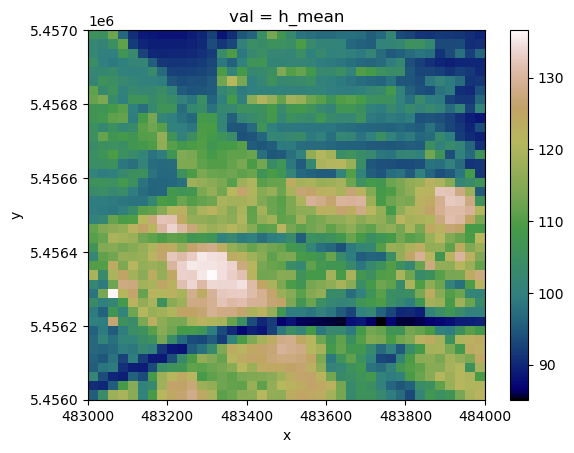

In [16]:
tmp.plot(cmap="gist_earth")

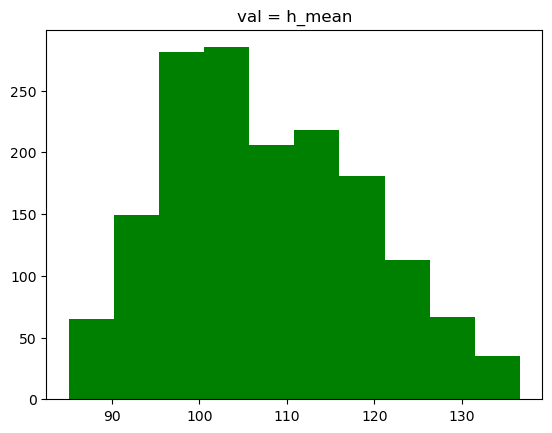

In [17]:
tmp.plot.hist(color="green")
plt.show()

# Exportar métricas

In [18]:
raster = tmp.rio

In [19]:
type(raster)

rioxarray.raster_array.RasterArray

In [20]:
raster.shape

(40, 40)

# Guardar en disco

In [ ]:
tmp.rio.to_raster(r"D:\LISAR\4830E_Hmean_white.tif")

# Despliegue visual


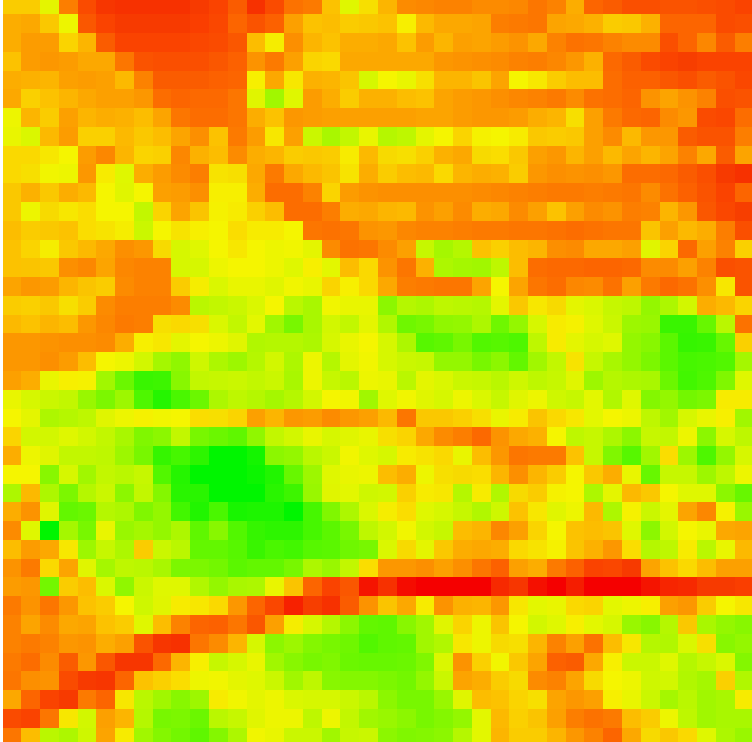

In [2]:
from IPython import display
display.Image(r"D:/LISAR/4830E_Hmean.png")

In [25]:
!pip install fpdf2


In [26]:
from fpdf import FPDF

font_path = r"C:\Windows\Fonts\arial.ttf"  # <-- CAMBIA esta ruta según tu sistema

pdf = FPDF()
pdf.add_page()

# Registrar fuente TrueType con soporte Unicode
pdf.add_font("MyUnicode", "", font_path, uni=True)
pdf.set_font("MyUnicode", size=10)

with open("week11_lisar.ipynb", "r", encoding="utf-8") as f:
    for linea in f:
        pdf.multi_cell(0, 5, linea)

pdf.output("codigo_generado.pdf")
print("✅ PDF creado: codigo_generado.pdf")


✅ PDF creado: codigo_generado.pdf
